# Quickstart: Use Cases and Examples with *Interpretable OPE Evaluator*

This notebook demonstrates an example of conducting Interpretable Evaluation for Off-Policy Evaluation (IEOE). We use logged bandit feedback data generated by modifying multiclass classification data using [`obp`](https://github.com/st-tech/zr-obp) and evaluate the performance of Direct Method (DM), Doubly Robust (DR), Doubly Robust with Shrinkage (DRos), and Inverse Probability Weighting (IPW).

Our example contains the following three major steps:

1. Data Preparation
2. Setting Hyperparameter Spaces for Off-Policy Evaluation
3. Interpretable Evaluation for Off-Policy Evaluation

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RandomForest

# import necesarry functions from obp
import obp
from obp.dataset import MultiClassToBanditReduction
from obp.policy import IPWLearner
from obp.ope import (
    DirectMethod,
    DoublyRobust,
    DoublyRobustWithShrinkage,
    InverseProbabilityWeighting,
)

# import interpretable ope evaluator from pyieoe
from pyieoe.evaluator import InterpretableOPEEvaluator

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
obp.__version__

'0.4.0'

## 1. Data Preparation

In order to conduct IEOE using `pyieoe`, we need to prepare logged bandit feedback data, action distributions of evaluation policies, and ground truth policy values of evaluation policies. Because `pyieoe` is built with the intention of being used with `obp`, these inputs must follow the conventions in `obp`. Specifically, logged bandit feedback data must be of type `BanditFeedback`, action distributions must be of type `np.ndarray`, and ground truth policy values must be of type `float` (or `int`). 

In this example, we generate logged bandit feedback data by modifying multiclass classification data and obtain two sets of evaluation policies along with their action distributions and ground truth policy values using `obp`. For a detailed explanation of this process, please refer to the [official docs](https://zr-obp.readthedocs.io/en/latest/_autosummary/obp.dataset.multiclass.html#module-obp.dataset.multiclass).

In [4]:
# load raw digits data
X, y = load_digits(return_X_y=True)
# convert the raw classification data into the logged bandit dataset
dataset = MultiClassToBanditReduction(
    X=X,
    y=y,
    base_classifier_b=LogisticRegression(random_state=12345),
    alpha_b=0.8,
    dataset_name="digits"
)
# split the original data into the training and evaluation sets
dataset.split_train_eval(eval_size=0.7, random_state=12345)
# obtain logged bandit feedback generated by the behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=12345)

# obtain action choice probabilities by an evaluation policy and its ground-truth policy value
action_dist_a = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=LogisticRegression(C=100, random_state=12345, max_iter=10000),
    alpha_e=0.9
)
ground_truth_a = dataset.calc_ground_truth_policy_value(action_dist=action_dist_a)
action_dist_b = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForest(n_estimators=100, min_samples_split=5, random_state=12345),
    alpha_e=0.9
)
ground_truth_b = dataset.calc_ground_truth_policy_value(action_dist=action_dist_b)

## 2. Setting Hyperparameter Spaces for Off-Policy Evaluation

An integral aspect of IEOE is the different sources of variance. The main sources of variance are evaluation policies, random states, hyperparameters of OPE estimators, and hyperparameters of regression models. 

In this step, we define the spaces from which the hyperparameters of OPE estimators / regression models are chosen. (The evaluation policy space is defined in the previous step, and the random state space will be defined in the next step.)

In [5]:
# set hyperparameter space for ope estimators

# set hyperparameter space for the doubly robust with shrinkage estimator
# with the following code, lambda_ will be chosen from a logarithm uniform distribution over the interval [0.001, 1000]
lambda_ = {
    "lower": 1e-3,
    "upper": 1e3,
    "log": True,
    "type": float
}
dros_param = {"lambda_": lambda_}

In [6]:
# set hyperparameter space for regression models

# set hyperparameter space for logistic regression
# with the following code, C will be chosen from a logarithm uniform distribution over the interval [0.001, 100]
# the chosen value will be of type float
C = {
    "lower": 1e-3,
    "upper": 1e2,
    "log": True,
    "type": float
}
# with the following code, max_iter will be fixed at 10000 and of type int
max_iter = {
    "lower": 1e4,
    "upper": 1e4,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
logistic_regression_param = {
    "C": C,
    "max_iter": max_iter
}

# set hyperparameter space for random forest classifier
# with the following code, n_estimators will be chosen from a logarithm uniform distribution over the interval [50, 100]
# the chosen value will be of type int
n_estimators = {
    "lower": 5e1,
    "upper": 1e2,
    "log": True,
    "type": int
}
# with the following code, max_depth will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
max_depth = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# with the following code, min_samples_split will be chosen from a uniform distribution over the interval [2, 10]
# the chosen value will be of type int
min_samples_split = {
    "lower": 2,
    "upper": 10,
    "log": False,
    "type": int
}
# create a dictionary mapping hyperparamter names to hyperparamter spaces
random_forest_param = {
    "n_estimators": n_estimators, 
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split
}

## 3. Interpretable Evaluation for Off-Policy Evaluation

With the above steps completed, we can finally conduct IEOE by utilizing the `InterpretableOPEEvaluator` class.

Here is a brief description for each parameter that can be passed into `InterpretableOPEEvaluator`:

- `random_states`: a list of integers representing the random_state used when performing OPE; corresponds to the number of iterations
- `bandit_feedback`: a list of logged bandit feedback data
- `evaluation_policies`: a list of tuples representing (ground truth policy value, action distribution)
- `ope_estimators`: a list of OPE ope_estimators
- `ope_estimator_hyperparams`: a dictionary mapping OPE estimator names to OPE estimator hyperparameter spaces defined in step 2
- `regression_models`: a list of regression regression_models
- `regression_model_hyperparams`: a dictionary mapping regression models to regression model hyperparameter spaces defined in step 2

In [7]:
# initializing class
evaluator = InterpretableOPEEvaluator(
    random_states=np.arange(1000),
    bandit_feedbacks=[bandit_feedback],
    evaluation_policies=[
        (ground_truth_a, action_dist_a), 
        (ground_truth_b, action_dist_b)
    ],
    ope_estimators=[
        DirectMethod(),
        DoublyRobust(),
        DoublyRobustWithShrinkage(),
        InverseProbabilityWeighting(), 
    ],
    ope_estimator_hyperparams={
        DoublyRobustWithShrinkage.estimator_name: dros_param,
    },
    regression_models=[
        LogisticRegression,
        RandomForest
    ],
    regression_model_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    },
    pscore_estimators=[
        LogisticRegression,
        RandomForest
    ],
    pscore_estimator_hyperparams={
        LogisticRegression: logistic_regression_param,
        RandomForest: random_forest_param
    }
)

We can set the hyperparameters of OPE estimators / regression models after initializing `InterpretableOPEEvaluator` as well. Below is an example:

In [8]:
# re-set hyperparameter space for doubly robust with shrinkage estimator
# with the following code, lambda_ will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_ope_estimator_hyperparam_space(
    DoublyRobustWithShrinkage.estimator_name,
    param_name="lambda_",
    lower=1e-3,
    upper=1e2,
    log=True,
    type_=float,
)

# re-set hyperparameter space for logistic regression
# with the following code, C will now be chosen from a logarithm uniform distribution over the interval [0.001, 100]
evaluator.set_regression_model_hyperparam_space(
    LogisticRegression,
    param_name="C",
    lower=1e-2,
    upper=1e2,
    log=True,
    type_=float,
)

Once we have initialized `InterpretableOPEEvaluator`, we can call implemented methods to perform IEOE.

In [9]:
# estimate policy values
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the estimated policy value for each iteration
policy_value = evaluator.estimate_policy_value()

100%|██████████| 1000/1000 [35:36<00:00,  2.14s/it] 


In [10]:
print("dm:", policy_value["dm"][:3])
print("dr:", policy_value["dr"][:3])
print("dr-os:", policy_value["dr-os"][:3])
print("ipw:", policy_value["ipw"][:3])

dm: [0.81096739 0.78412865 0.78712081]
dr: [0.8253112  1.00228582 0.78789132]
dr-os: [0.82473807 0.78602363 0.78783993]
ipw: [1.01482753 1.11752925 1.0182291 ]


In [11]:
# compute squared errors
# we obtain a dictionary mapping ope estimator names to np.ndarray storing the calculated squared error for each iteration
squared_error = evaluator.calculate_squared_error()

In [12]:
print("dm:", squared_error["dm"][:3])
print("dr:", squared_error["dr"][:3])
print("dr-os:", squared_error["dr-os"][:3])
print("ipw:", squared_error["ipw"][:3])

dm: [0.00253854 0.00748626 0.00551017]
dr: [0.00129889 0.01732751 0.00539638]
dr-os: [0.00134053 0.00716193 0.00540393]
ipw: [0.02355494 0.06094846 0.02461063]


<Figure size 432x288 with 0 Axes>

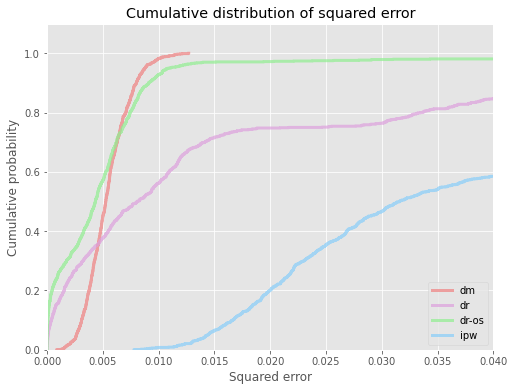

In [18]:
# visualize cdf of squared errors for all ope estimators
evaluator.visualize_cdf_aggregate(xmax=0.04)

In [14]:
# compute the au-cdf score (area under cdf of squared error over interval [0, thershold]), higher score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
au_cdf = evaluator.calculate_au_cdf_score(threshold=0.004)
au_cdf

{'dm': 0.00021056405032585993,
 'dr': 0.0008879177361003537,
 'dr-os': 0.001237122081750088,
 'ipw': 0.0}

In [15]:
# by activating the `scale` option, 
# we obtain au_cdf scores where the highest score is scaled to 1
au_cdf_scaled = evaluator.calculate_au_cdf_score(threshold=0.004, scale=True)
au_cdf_scaled

{'dm': 0.17020474650972736, 'dr': 0.71772846770649, 'dr-os': 1.0, 'ipw': 0.0}

In [16]:
# compute the cvar score (expected value of squared error above probability alpha), lower score is better
# we obtain a dictionary mapping ope estimator names to cvar scores 
cvar = evaluator.calculate_cvar_score(alpha=90)
cvar

{'dm': 0.009140229299153585,
 'dr': 0.16904269955964735,
 'dr-os': 0.024619638962354397,
 'ipw': 3.111787619643494}

In [17]:
# by activating the `scale` option, 
# we obtain cvar scores where the lowest score is scaled to 1
cvar_scaled = evaluator.calculate_cvar_score(alpha=90, scale=True)
cvar_scaled

{'dm': 1.0,
 'dr': 18.494360921043988,
 'dr-os': 2.6935471919325105,
 'ipw': 340.44962306707725}